In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import os
import sys
from numpy import random
import time
import pandas as pd

# Add QDYN directory to PATH
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/src')  # For pyqdyn
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/utils/post_processing') # For plot_functions
print(sys.path)
from pyqdyn import qdyn
import plot_functions as qdyn_plot

['/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/examples/elif/40L_homogeneous', '/Users/elifo/Python/Progs', '/Users/elifo/opt/anaconda3/lib/python38.zip', '/Users/elifo/opt/anaconda3/lib/python3.8', '/Users/elifo/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/smtk-0.9.0_gite2e537d-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/openquake.engine-3.10.1-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/scipy-1.4.1-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/requests-2.23.0-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/pyshp-1.2.3-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/psutil-5.6.7-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/IPython/extensi

# Set up the model

In [3]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600.0* 24.0* 365.0    # seconds per year
Lasp = 40                     # Length of asperity (VW) / nucleation length
L = 4                         # Length of model / Lasp
a = 0.014
b = 0.019
resolution = 5                # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # 
set_dict["TMAX"] = 300*t_yr      # Maximum simulation time [s]
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 120e6        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-10         # Solver accuracy
# set_dict["SOLVER"] = 1         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = a          # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = b          # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 2e-3      # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = 1e-9    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]


# Compute relevant length scales:
Lc = 2.0/ np.pi* set_dict["MU"]* set_dict["SET_DICT_RSF"]["DC"]* b/  \
                     (set_dict["SIGMA"]* (b-a)** 2.0)
print ('Nucleation length (m): ', Lc)

Lb = 9.0* np.pi/ 32.0* set_dict["MU"]* set_dict["SET_DICT_RSF"]["DC"]/ \
                      (set_dict["SIGMA"]* b)
print ('Process zone width (m): ', Lb)

# Length of asperity [m]
Lasp *= Lc
# Fault length [m]
L *= Lasp

print ('VW patch (asperity) size, Lasp (m, Lc): ', Lasp, Lasp/Lc)
print ('Model size, L (m, Lc): ', L, L/Lc)


# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Set time series output node to the middle of the fault
set_dict["IC"] = N // 2

# output settings
set_dict['NXOUT'] = max(1, set_dict['NXOUT']/1024) # Snapshot resolution (every N elements)
set_dict["NTOUT"] = 10                             # Save output every N steps


""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
# outside VW patch, set a = (3b-a) after benjamin's
cdt = (abs(x) > Lasp/ 2.0)
p.mesh_dict["A"][cdt] = 3.0* p.mesh_dict["B"][cdt]- a
print (p.mesh_dict["A"][cdt])

# Write input to qdyn.in
p.write_input()


Nucleation length (m):  241.91551349968103
Process zone width (m):  23.251919311108665
VW patch (asperity) size, Lasp (m, Lc):  9676.620539987242 40.0
Model size, L (m, Lc):  38706.482159948966 160.0
[0.043 0.043 0.043 ... 0.043 0.043 0.043]


True

# Frictional heterogeneity
set by a-parameter variation along fault

In [4]:
# plt.figure(figsize=(4,3))
# plt.plot(x/Lc, p.mesh_dict["A"] - p.mesh_dict["B"])
# plt.axhline(0, ls=":", c="k")
# plt.xlabel("position [Lnuc]")
# plt.ylabel("(a-b) [-]")
# plt.tight_layout()
# # plt.savefig("asperity_a-b.png")
# plt.show()

# Quick check of simulation outputs

In [3]:
### POST-PROCESS ###
p.read_output(read_ox=False)

True

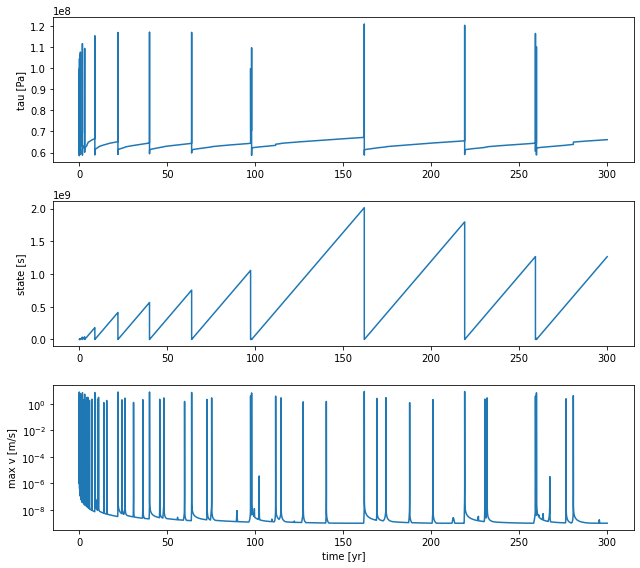

In [4]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

# Read 2D data 

In [5]:
# READ ONLY CHUNK FILE of OX
filename = 'output_ox_chunk_15'

quants_ox = ("t", "x", "y", "z", "v", "theta", "tau", "tau_dot", "slip", "sigma")

dum = pd.read_csv(filename, header=None, names=quants_ox, delim_whitespace=True, comment="#")
dum

,t,x,y,z,v,theta,tau,tau_dot,slip,sigma
1500000000,8.175477e+09,9073.012984,0.0,0.0,9.465557e-10,2280444.0,72015770.0,0.0,54.68971,120000000.0
1500000001,8.175477e+09,9075.375441,0.0,0.0,9.466157e-10,2280154.0,72015810.0,0.0,54.68748,120000000.0
1500000002,8.175477e+09,9077.737897,0.0,0.0,9.466761e-10,2279865.0,72015850.0,0.0,54.68524,120000000.0
1500000003,8.175477e+09,9080.100353,0.0,0.0,9.467360e-10,2279576.0,72015890.0,0.0,54.68300,120000000.0
1500000004,8.175477e+09,9082.462809,0.0,0.0,9.467964e-10,2279288.0,72015930.0,0.0,54.68076,120000000.0
...,...,...,...,...,...,...,...,...,...,...
1556365307,9.461619e+09,19342.610027,0.0,0.0,9.981488e-10,2003690.0,71994640.0,0.0,11.35581,120000000.0
1556365308,9.461619e+09,19344.972483,0.0,0.0,9.983529e-10,2003283.0,71995230.0,0.0,11.14446,120000000.0
1556365309,9.461619e+09,19347.334940,0.0,0.0,9.985941e-10,2002802.0,71995930.0,0.0,10.89583,120000000.0
1556365310,9.461619e+09,19349.697396,0.0,0.0,9.988746e-10,2002242.0,71996740.0,0.0,10.60783,120000000.0


8181965269.0311 8642642245.1293
data_shape (Nt, Nx): (1941, 16384)
(1941, 16384) (1941, 16384) (1941, 16384)


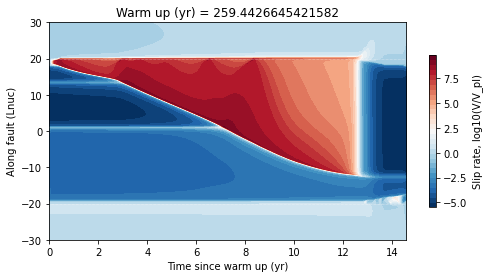

In [12]:
t_beg, t_end = dum['t'].values[0], dum['t'].values[-1]
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg+0.2*t_yr, t_end=t_beg+15*t_yr,V_pl=1e-9,Lvw=20,Lc=Lc)

In [5]:
%%time

# READ ONLY CHUNK FILE of OX
filename = 'output_ox_chunk_14'

quants_ox = ("t", "x", "y", "z", "v", "theta", "tau", "tau_dot", "slip", "sigma")

dum = pd.read_csv(filename, header=None, names=quants_ox, delim_whitespace=True, comment="#")
dum

CPU times: user 1min 43s, sys: 29.8 s, total: 2min 13s
Wall time: 2min 26s


,t,x,y,z,v,theta,tau,tau_dot,slip,sigma
1400000000,5.107628e+09,-10885.016879,0.0,0.0,9.563845e-10,2356296.0,72143680.0,0.0,49.11545,120000000.0
1400000001,5.107628e+09,-10882.654423,0.0,0.0,9.563578e-10,2356519.0,72143750.0,0.0,49.11898,120000000.0
1400000002,5.107628e+09,-10880.291967,0.0,0.0,9.563308e-10,2356741.0,72143820.0,0.0,49.12251,120000000.0
1400000003,5.107628e+09,-10877.929511,0.0,0.0,9.563041e-10,2356963.0,72143890.0,0.0,49.12603,120000000.0
1400000004,5.107628e+09,-10875.567055,0.0,0.0,9.562771e-10,2357186.0,72143960.0,0.0,49.12955,120000000.0
...,...,...,...,...,...,...,...,...,...,...
1499999995,8.175477e+09,9061.200703,0.0,0.0,9.462537e-10,2281897.0,72015580.0,0.0,54.70087,120000000.0
1499999996,8.175477e+09,9063.563160,0.0,0.0,9.463144e-10,2281606.0,72015620.0,0.0,54.69864,120000000.0
1499999997,8.175477e+09,9065.925616,0.0,0.0,9.463745e-10,2281315.0,72015660.0,0.0,54.69641,120000000.0
1499999998,8.175477e+09,9068.288072,0.0,0.0,9.464351e-10,2281024.0,72015700.0,0.0,54.69418,120000000.0


5107628292.2589 8175476669.0015
data_shape (Nt, Nx): (6103, 16384)
(6103, 16384) (6103, 16384) (6103, 16384)


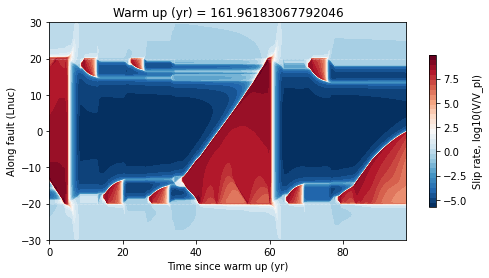

In [6]:
t_beg, t_end = dum['t'].values[0], dum['t'].values[-1]
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg, t_end=t_end,V_pl=1e-9,Lvw=20,Lc=Lc)

6065721844.557 7027803679.3985
data_shape (Nt, Nx): (2313, 16384)
(2313, 16384) (2313, 16384) (2313, 16384)


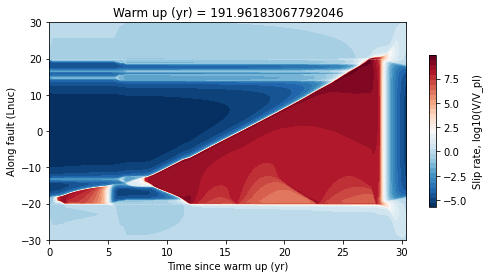

In [7]:
t_beg, t_end = dum['t'].values[0], dum['t'].values[-1]
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg+30*t_yr, t_end=t_beg+61*t_yr,V_pl=1e-9,Lvw=20,Lc=Lc)

In [ ]:
#fin